# Well log analysis: SPWLA 2020 Petrophysical Data-Driven Analytics Contest

In 2020, [SWPLA](https://www.spwla.org/) (Society of Petrophysicists and Well Log Analysts) organized a contest to test the ability of machine-learning algorithms to analyze well-log information.

## Background information

https://github.com/pddasig/Machine-Learning-Competition-2020

Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, such as gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, such as nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

![](http://www.ingenieriadepetroleo.com/wp-content/uploads/2013/01/Sonic-log.-a-Schematic-compensated-sonic-logging-sonde.-b-Sonic-log..jpg)


[Sonic travel-time logs](https://wiki.seg.org/wiki/Dictionary:Sonic_log) contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.

### Download data

In [ ]:
import requests

url = "https://github.com/pddasig/Machine-Learning-Competition-2020/raw/master/Data3_1_2020.zip"
response = requests.get(url)
with open("Data3_1_2020.zip", "wb") as f:
    f.write(response.content)


In [ ]:
# Extract training data

import zipfile
with zipfile.ZipFile('Data3_1_2020.zip', 'r') as zipf:
    zipf.extract('train.csv')

The data is in the form of a CSV (comma-separated values) file. Different rows correspond to different depth levels in the borehole, and different columns correspond to different logs.

We will use [pandas](https://pandas.pydata.org/), Python data analysis library, for managing data.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Pandas_logo.svg/512px-Pandas_logo.svg.png)

In [ ]:
import pandas as pd

In [ ]:
# load data from CSV file

logs = pd.read_csv('train.csv')
logs.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,-999.0,-999.0,41.4699,-999.0,-999.0,-999.0,-999.0,128.0737,319.0654
1,-999.0,-999.0,42.5053,-999.0,-999.0,-999.0,-999.0,127.8347,318.7825
2,-999.0,-999.0,43.1548,-999.0,-999.0,-999.0,-999.0,127.2307,317.3323
3,-999.0,-999.0,43.2410,-999.0,-999.0,-999.0,-999.0,126.2917,313.6486
4,-999.0,-999.0,40.3218,-999.0,-999.0,-999.0,-999.0,125.3985,307.8903


In [ ]:
# data information
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAL     30143 non-null  float64
 1   CNC     30143 non-null  float64
 2   GR      30143 non-null  float64
 3   HRD     30143 non-null  float64
 4   HRM     30143 non-null  float64
 5   PE      30143 non-null  float64
 6   ZDEN    30143 non-null  float64
 7   DTC     30143 non-null  float64
 8   DTS     30143 non-null  float64
dtypes: float64(9)
memory usage: 2.1 MB


In [ ]:
# data attributes
logs.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


# Meaning of different columns

| Key | Description | Unit |
|-----|-------------|------|
| **CAL** | Caliper log | inch |
| **CNC** | Neutron log  | dec  |
| **GR**  | Gamma Ray log | API |
| **HRD** | Deep Resistivity log | Ohm per meter |
| **HRM** | Medium Resistivity log  | Ohm per meter |
| **PE**  | Photo-Electric Factor log | Barn |
| **ZDEN**| Density log | grams per cubic meter |
| **DTC** | Compressional Travel-time log | nanosecond per foot |
| **DTS** | Shear Travel-time log | nanosecond per foot |

Values set to -999 mark missing values.

## Attempt to predict sonic from density

We will start by selecting only two logs (ZDEN and DTC) and will attempt to predict one from the other using a simple linear regression. The attempt may not succeed but it will illustrate the general setup of the problem.

First, let us drop missing or anomalous values and examine the data distribution.

In [ ]:
import numpy as np

# select two logs
two = logs.loc[:, ('ZDEN', 'DTC')]
# replace -999 with NaN
two.replace(-999, np.nan, inplace=True)
# drop rows with NaN
two.dropna(inplace=True)
# data information
two.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25516 entries, 573 to 30142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    25516 non-null  float64
 1   DTC     25516 non-null  float64
dtypes: float64(2)
memory usage: 598.0 KB


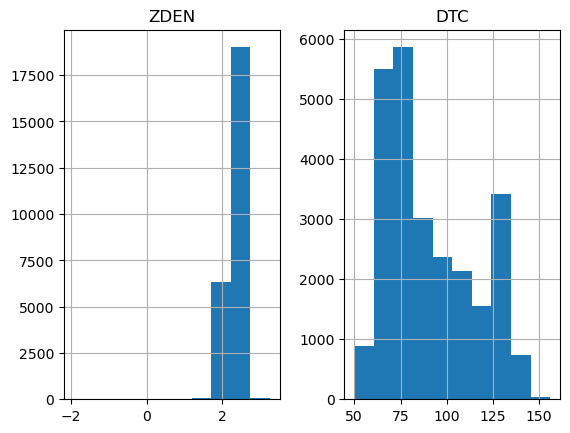

In [ ]:
# display histogram
hist = two.hist()

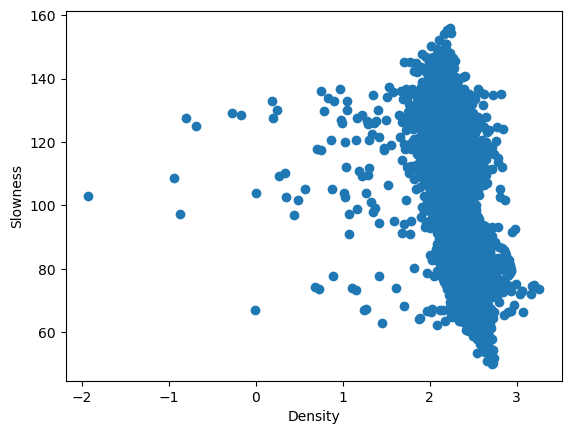

In [ ]:
# display scatter plot

import matplotlib.pyplot as plt
plt.scatter(two.ZDEN, two.DTC)
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

In [ ]:
# remove anomalous density values
two2 = two.loc[(two.ZDEN > 1.5) & (two.ZDEN < 3.1)]
two2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25442 entries, 573 to 30142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    25442 non-null  float64
 1   DTC     25442 non-null  float64
dtypes: float64(2)
memory usage: 596.3 KB


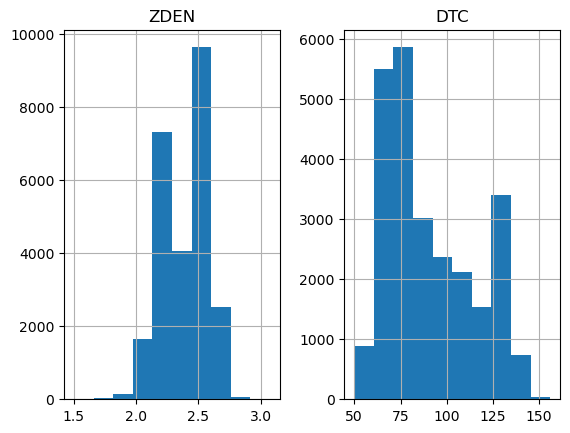

In [ ]:
two2_hist = two2.hist()

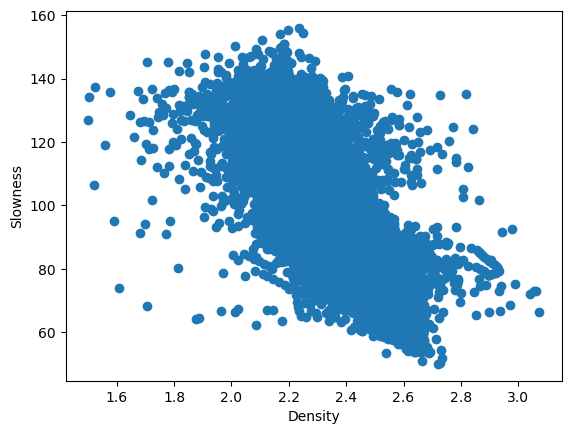

In [ ]:
plt.scatter(two2.ZDEN, two2.DTC)
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

The dependence is not simple but we can observe a general trend of slowness decreasing with density. Next, we will try to approximate this dependence with a straight line by using *linear regression*, a classic tool from statistics.

How do we know if our model works? We can divide the data in two parts: training and testing. We can then use the training part to fit the model and the testing part to validate the result. We will select 80% of the data for training and the remaining 20% for validation.

In [ ]:
# divide into training and testing
select = np.random.rand(len(two2)) < 0.8
train = two2[select]
test = two2[~select]

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20276 entries, 573 to 30142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    20276 non-null  float64
 1   DTC     20276 non-null  float64
dtypes: float64(2)
memory usage: 475.2 KB


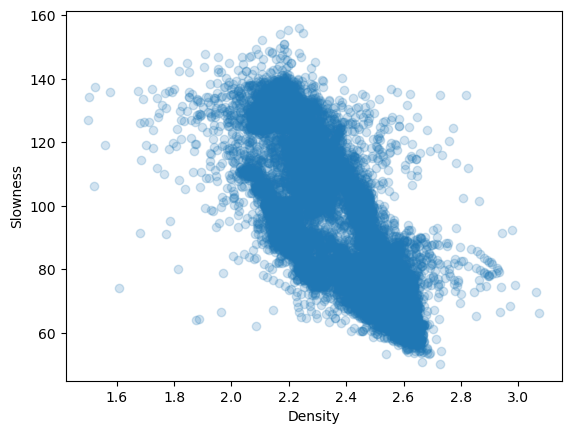

In [ ]:
plt.scatter(train.ZDEN, train.DTC, alpha=0.2)
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

## Linear regression

Linear regression, together with more sophisticated models, is provided by [scikit-learn](https://scikit-learn.org/), a package for classic machine learning algorithms.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/320px-Scikit_learn_logo_small.svg.png)

In [ ]:
# create model
from sklearn import linear_model
model = linear_model.LinearRegression()

# train model
model.fit(train[['ZDEN']], train['DTC'])

LinearRegression()

Our first model has only two parameters: the intercept $a$ and the slope $b$ and in the equation
$$s(\rho)=a+b\,\rho\;.$$
Fitting the model means estimating these parameters from the data.

In [ ]:
# regression coefficients
print('Intercept: ', model.intercept_)
print('Coefficients: ', model.coef_)

Intercept:  341.62454840548116
Coefficients:  [-104.88844653]


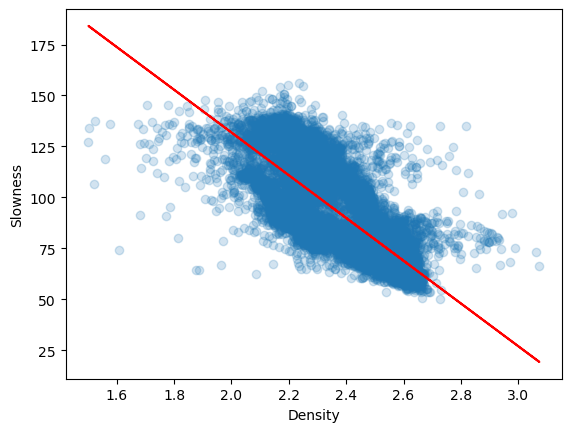

In [ ]:
plt.scatter(train.ZDEN, train.DTC, alpha=0.2)
plt.plot(train.ZDEN, model.intercept_ +
        train.ZDEN*model.coef_[0], '-r')
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

Now we can turn to the testing data and see how well our model predicts it.

There are different ways to measure the error. If $p_n$ are predicted values, and $v_n$ are actual values, the classic linear regression is using the least-squares misfit $\displaystyle \sum_{n=1}^{N} (p_n - v_n)^2$.

The root-mean-square error is defined as $\displaystyle  \sqrt{\frac{1}{N} \sum_{n=1}^{N} (p_n - v_n)^2}$.

In [ ]:
# evaluate prediction error
from sklearn.metrics import mean_squared_error
want = test['DTC']
get = model.predict(test[['ZDEN']])

print("RMS error: %.3f" % np.sqrt(np.mean((get-want)**2)))
print("RMS error: %.3f" % mean_squared_error(get, want,
                                             squared=False))

RMS error: 14.516
RMS error: 14.516


In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error?

Signature:
mean_squared_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
    squared=True,
)
Docstring:
Mean squared error regression loss.

Read more in the :ref:`User Guide <mean_squared_error>`.

Parameters
----------
y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Estimated target values.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

multioutput : {'raw_values', 'uniform_average'} or array-like of shape             (n_outputs,), default='uniform_average'
    Defines aggregating of multiple output values.
    Array-like value defines weights used to average errors.

    'raw_values' :
        Returns a full set of errors in case of multioutput input.

    'uniform_average' :
        Errors of all outputs are averaged with uniform weight.

squared : bool, default=Tr

## How does it work?

Parameters of the model are estimated by minimizing the desired objective function. In the case of linear regression, the dependence on parameters is quadratic, and the minimum is found analytically. In the more general case, the minimization is achieved by some form of gradient descent.

In [ ]:
#This function calculates the root mean squared error (RMSE) between the observed data and the data predicted by the model given parameters
#a and b. It uses the train DataFrame to get the 'ZDEN' and 'DTC' columns, which seem to represent different measurements.
#It uses these measurements to calculate the predicted values with the formula a + b * d, where d is the 'ZDEN' values from the DataFrame.
#The mean_squared_error function is used with the squared=False parameter to calculate the root mean squared error.

def least_squares(a, b):
    d = train['ZDEN']
    s = train['DTC']
    return mean_squared_error(a+b*d, s, squared=False)

#This code creates a grid of parameter values a and b.
#It does this by generating two sets of values using the linspace function: one for the range of a values and one for the range of b values.
#The np.meshgrid function then creates two 2D arrays a and b, which cover all combinations of the parameter values in the specified ranges.

a, b = np.meshgrid(
    np.linspace(start=-400, stop=1000, num=101),
    np.linspace(start=-400, stop=200, num=101))

#Here, the np.vectorize function is used to vectorize the least_squares function, which means it's adapted to work with arrays instead of
#single values. The vectorized function is then applied to the meshgrid arrays a and b,
#resulting in a 2D array error where each element represents the root mean squared error for a specific combination of a and b.

error = np.vectorize(least_squares)(a, b)

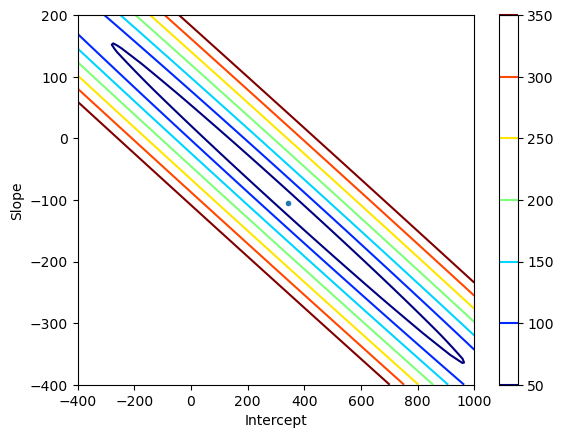

In [ ]:
# plot surface
plt.contour(a, b, error, [50, 100, 150, 200, 250, 300, 350], cmap='jet')
plt.plot(model.intercept_, model.coef_[0], marker='.')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.colorbar()
plt.show()

#Blue: Lower RMSE values
#Green: Intermediate RMSE values
#Yellow: Higher RMSE values
#Red: Highest RMSE values


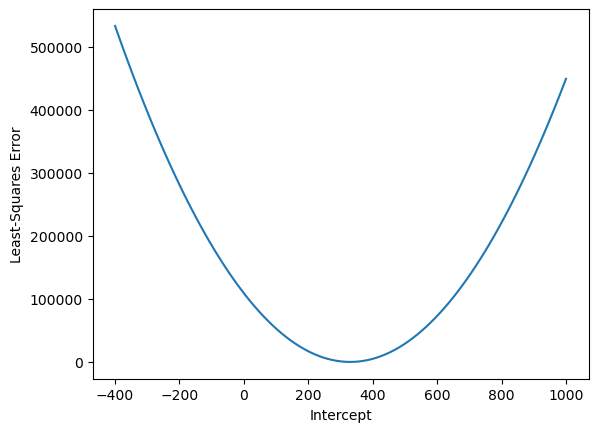

In [ ]:
a = np.linspace(start=-400, stop=1000, num=101)
error = np.vectorize(least_squares)(a, -100)**2
plt.plot(a, error)
plt.xlabel('Intercept')
plt.ylabel('Least-Squares Error')
plt.show()

## How can we improve it?

One approach to complicate the dependence would be to extend the model, for example from a line to a parabola.

In [ ]:
# extend the model with density raised to degree 2
train = train.assign(ZDEN2=np.power(train.ZDEN, 2))
train.describe()

,ZDEN,DTC,ZDEN2
count,20276.000000,20276.000000,20276.000000
mean,2.389723,90.970218,5.744107
std,0.182574,23.952487,0.862772
min,1.501600,50.278700,2.254803
25%,2.222200,71.183000,4.938173
50%,2.429800,83.449750,5.903928
75%,2.553600,109.846700,6.520873
max,3.073500,155.980300,9.446402


In [ ]:
# create model
model2 = linear_model.LinearRegression()

# train model
model2.fit(train[['ZDEN', 'ZDEN2']], train['DTC'])

LinearRegression()

In [ ]:
# regression coefficients
print('Intercept: ', model2.intercept_)
print('Coefficients: ', model2.coef_)

Intercept:  193.54681473340565
Coefficients:  [ 21.33006569 -26.73166289]


The model changes from
$$s(\rho) = a + b\,\rho$$
to
$$s(\rho) = a + b_1\,\rho + b_2\,\rho^2$$

and involves three parameters ($a,b_1,b_2$) instead of two ($a,b$) as in the previous case.

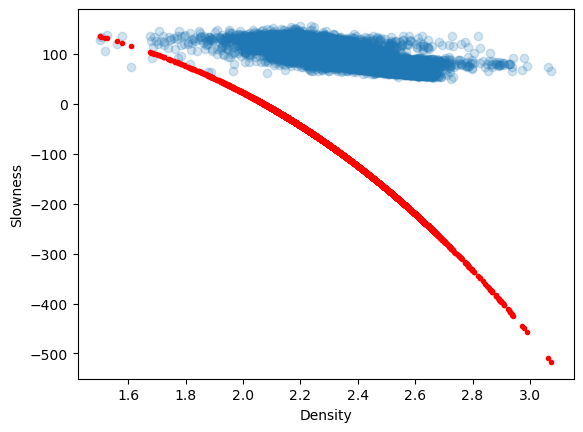

In [ ]:
plt.scatter(train.ZDEN, train.DTC, alpha=0.2)
parabola = model2.intercept_ + train.ZDEN * \
    model2.coef_[0] + train.ZDEN2*model2.coef_[1]
plt.plot(train.ZDEN, parabola, '.r')
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

In [ ]:
test = test.assign(ZDEN2=np.power(test.ZDEN, 2))

want = test['DTC']
get2 = model2.predict(test[['ZDEN', 'ZDEN2']])

print("RMS error: %.3f" % mean_squared_error(get2, want,
                                             squared=False))

RMS error: 14.449


## <span style="color:red">Task 1</span>

Can you improve the fit further by using a higher-degree polynomial?

$$s(\rho) = a_0 + b_1\,\rho + b_2\,\rho^2 + b_3\,\rho^3 + \cdots + b_N\,\rho^N$$

Choose $N \ge 3$ and add code to try it out.

In [ ]:
# extend the model with density raised to degree 3
train = train.assign(HRD=np.power(train.ZDEN, 3))
train.describe()

,ZDEN,DTC,ZDEN2,HRD
count,20276.000000,20276.000000,20276.000000,20276.000000
mean,2.389723,90.970218,13.884207,13.884207
std,0.182574,23.952487,3.075398,3.075398
min,1.501600,50.278700,3.385812,3.385812
25%,2.222200,71.183000,10.973608,10.973608
50%,2.429800,83.449750,14.345364,14.345364
75%,2.553600,109.846700,16.651701,16.651701
max,3.073500,155.980300,29.033517,29.033517


In [ ]:
# create model
model3 = linear_model.LinearRegression()

# train model
model3.fit(train[['ZDEN', 'ZDEN2', 'HRD']], train['DTC'])

LinearRegression()

In [ ]:
# regression coefficients
print('Intercept: ', model3.intercept_)
print('Coefficients: ', model3.coef_)

Intercept:  256.4702176218189
Coefficients:  [-5.11757824e+01 -5.44633445e+13  5.44633445e+13]


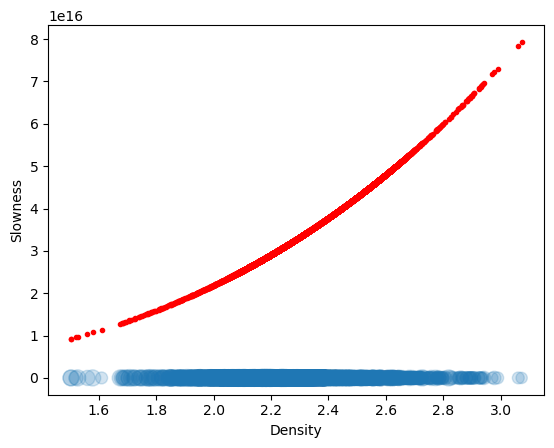

In [ ]:
plt.scatter(train.ZDEN, train.HRD, train.DTC, alpha=0.2)
parabola = model3.intercept_ + train.ZDEN * \
    model3.coef_[0] + train.HRD*model3.coef_[1] *\
    model3.coef_[0] + train.HRD*model3.coef_[1]
plt.plot(train.ZDEN, parabola, '.r')
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

In [ ]:
test = test.assign(HRD =np.power(test.ZDEN, 2))

want = test['DTC']
get3 = model3.predict(test[['ZDEN', 'ZDEN2', 'HRD']])

print("RMS error: %.3f" % mean_squared_error(get3, want,
                                             squared=False))

RMS error: 30.069


## More inputs

Another way to extend the model is to involve other logs.

Let us try the Gamma-ray log in addition to the density log.

In [ ]:
# select two logs
three = logs.loc[:, ['ZDEN', 'GR', 'DTC']]
# replace -999 with NaN
three.replace(-999, np.nan, inplace=True)
# drop rows with NaN
three.dropna(inplace=True)
# data information
three.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25473 entries, 573 to 30142
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    25473 non-null  float64
 1   GR      25473 non-null  float64
 2   DTC     25473 non-null  float64
dtypes: float64(3)
memory usage: 796.0 KB


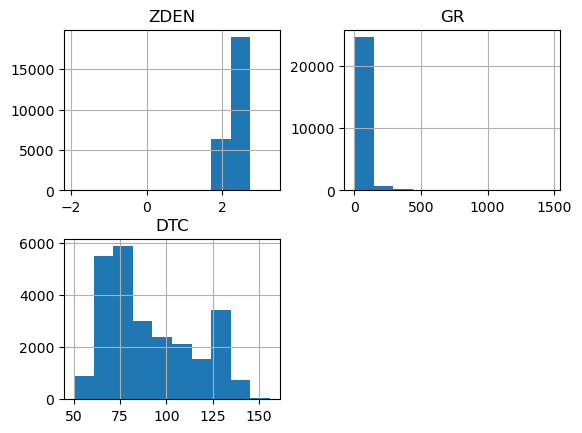

In [ ]:
three_hist = three.hist()

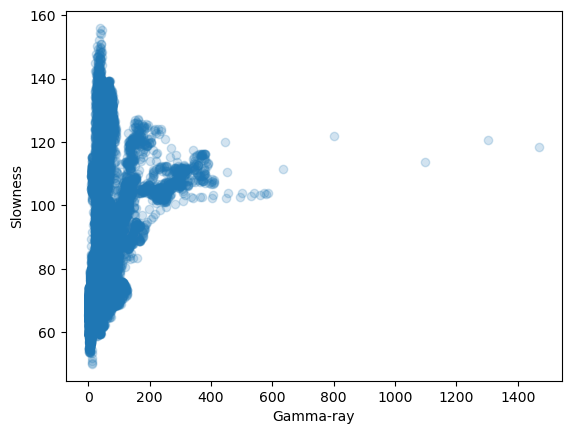

In [ ]:
# display scatter plot

import matplotlib.pyplot as plt
plt.scatter(three.GR, three.DTC, alpha=0.2)
plt.xlabel('Gamma-ray')
plt.ylabel('Slowness')
plt.show()

In [ ]:
# remove anomalous density values and anomalous gamma-ray values
three2=three.loc[(three.ZDEN > 1.5) & (three.ZDEN < 3.1) &
                 (three.GR < 400)]
three2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25372 entries, 573 to 30142
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    25372 non-null  float64
 1   GR      25372 non-null  float64
 2   DTC     25372 non-null  float64
dtypes: float64(3)
memory usage: 792.9 KB


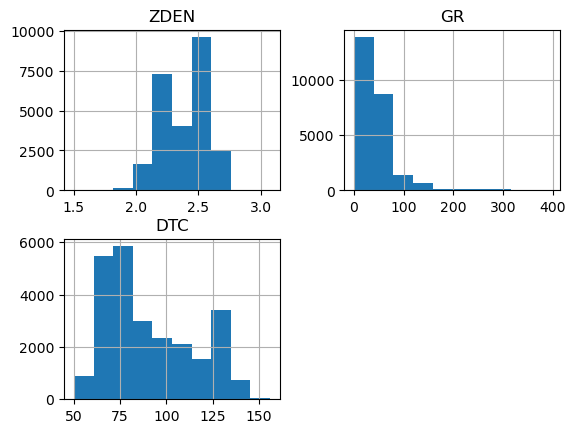

In [ ]:
three2_hist = three2.hist()

In [ ]:
# divide into training and testing
select3 = np.random.rand(len(three2)) < 0.8
train3 = three2[select3]
test3 = three2[~select3]

train3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20302 entries, 573 to 30142
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    20302 non-null  float64
 1   GR      20302 non-null  float64
 2   DTC     20302 non-null  float64
dtypes: float64(3)
memory usage: 634.4 KB


In [ ]:
# create model
model3 = linear_model.LinearRegression()

# train model
model3.fit(train3[['ZDEN', 'GR']], train3['DTC'])

LinearRegression()

In [ ]:
# regression coefficients
print('Intercept: ', model3.intercept_)
print('Coefficients: ', model3.coef_)

Intercept:  321.0124082925329
Coefficients:  [-98.69986653   0.12389372]


The model changes from
$$s(\rho) = a + b\,\rho$$
to
$$s(\rho,\gamma) = a + b\,\rho + c\,\gamma$$

and also involves three parameters ($a,b,c$) instead of two ($a,b$).

It represents a plane in the three-dimensional space instead of a line in the two-dimensional space.

In [ ]:
want3 = test3['DTC']
get3 = model3.predict(test3[['ZDEN', 'GR']])

print("RMS error: %.3f" % mean_squared_error(get3, want3,
                                             squared=False))

RMS error: 13.135


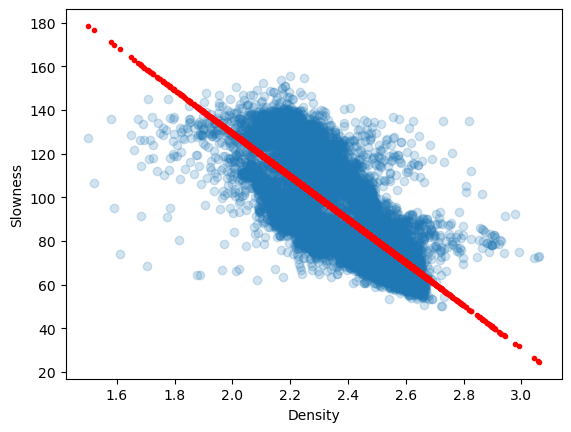

In [ ]:
plt.scatter(train3.ZDEN, train3.DTC, alpha=0.2)
plt.plot(train3.ZDEN, model3.intercept_ + train3.ZDEN *
         model3.coef_[0] +
         np.mean(train3.GR)*model3.coef_[1], '.r')
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

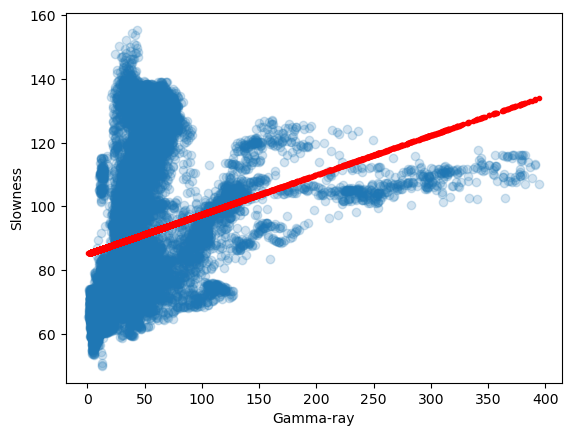

In [ ]:
plt.scatter(train3.GR, train3.DTC, alpha=0.2)
plt.plot(train3.GR, model3.intercept_ + np.mean(train3.ZDEN)
         * model3.coef_[0] + \
         train3.GR*model3.coef_[1], '.r')
plt.xlabel('Gamma-ray')
plt.ylabel('Slowness')
plt.show()

In [ ]:
D = np.linspace(np.min(train3.ZDEN), np.max(train3.ZDEN), 10)
G = np.linspace(np.min(train3.GR), np.max(train3.GR), 10)
D, G = np.meshgrid(D, G)
S = model3.intercept_ + D*model3.coef_[0] + \
G*model3.coef_[1]

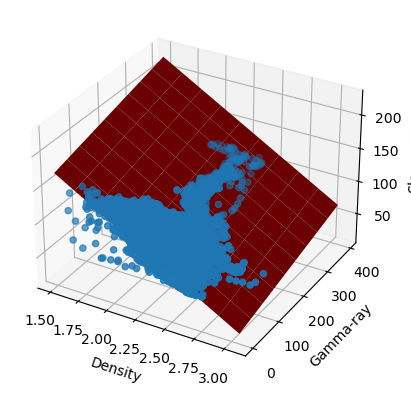

In [ ]:
axes = plt.axes(projection='3d')
axes.scatter(train3.ZDEN, train3.GR, train3.DTC)
axes.plot_surface(D, G, S, color='red')
axes.set_xlabel('Density')
axes.set_ylabel('Gamma-ray')
axes.set_zlabel('Slowness')
plt.show()

## <span style="color:red">Task 2</span>

Can you improve the fit further by using more logs for prediction in addition to density and gamma-ray?

$$s(l_1,l_2,\cdots,l_N) = a_0 + b_1\,l_1 + b_2\,l_2  + \cdots + b_N\,l_N$$

Choose $N \ge 3$ and add code to try it out.

The suitable logs are Neuron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-Electric Factor, and Density.

In [ ]:
import pandas as pd

# Assuming you've loaded and preprocessed your data into the 'logs' DataFrame
four = logs.loc[:, ['ZDEN', 'GR', 'DTC', 'PE']]
four.replace(-999, np.nan, inplace=True)
four.dropna(inplace=True)
four_df = pd.DataFrame(four, columns=['ZDEN', 'GR', 'DTC', 'PE'])


In [ ]:
print("Info for four_df DataFrame:")
print(four_df.info())


Info for four_df DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25473 entries, 573 to 30142
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    25473 non-null  float64
 1   GR      25473 non-null  float64
 2   DTC     25473 non-null  float64
 3   PE      25473 non-null  float64
dtypes: float64(4)
memory usage: 995.0 KB
None


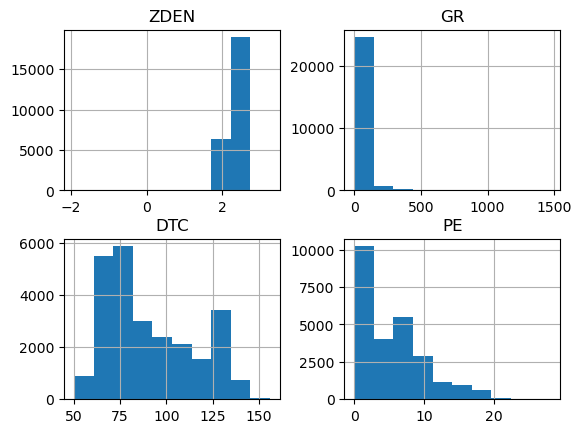

In [ ]:
four_hist = four_df.hist()

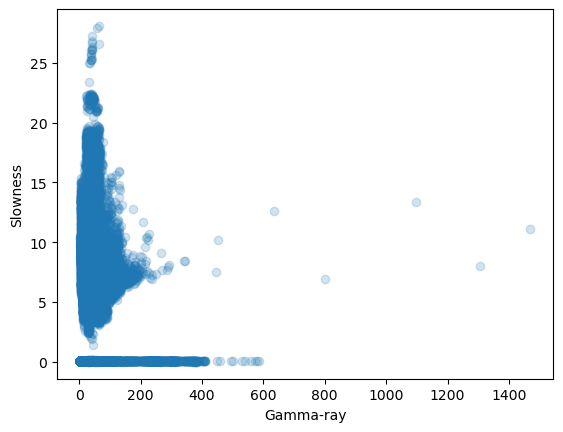

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(four_df.GR, four_df.PE, alpha=0.2)
plt.xlabel('Gamma-ray')
plt.ylabel('Slowness')
plt.show()


In [ ]:
# remove anomalous density values and anomalous gamma-ray values
four2_df = four_df.loc[(four_df.ZDEN > 1.5) & (four_df.DTC < 140) &
                       (four_df.GR < 400) & (four_df.PE < 500)]
# Display information about the filtered DataFrame
print("Info for four2_df DataFrame:")
print(four2_df.info())


Info for four2_df DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25279 entries, 573 to 30142
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    25279 non-null  float64
 1   GR      25279 non-null  float64
 2   DTC     25279 non-null  float64
 3   PE      25279 non-null  float64
dtypes: float64(4)
memory usage: 987.5 KB
None


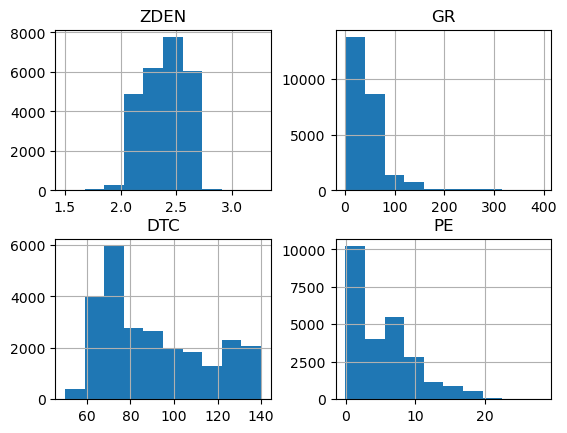

In [ ]:
# Display histogram of the filtered DataFrame
four2_hist = four2_df.hist()


In [ ]:
# Divide into training and testing using Pandas DataFrames
select4 = np.random.rand(len(four2_df)) < 0.8
train4_df = four2_df[select4]
test4_df = four2_df[~select4]

# Display information about the training DataFrame
print("Info for train4_df DataFrame:")
print(train4_df.info())


Info for train4_df DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20142 entries, 574 to 30142
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    20142 non-null  float64
 1   GR      20142 non-null  float64
 2   DTC     20142 non-null  float64
 3   PE      20142 non-null  float64
dtypes: float64(4)
memory usage: 786.8 KB
None


In [ ]:
# Create model
model4 = linear_model.LinearRegression()

# Train model
X_train = train4_df[['ZDEN', 'GR', 'PE']]  # Use ZDEN, GR, and DTS as features
y_train = train4_df['DTC']  # Use DTC as the target variable
model4.fit(X_train, y_train)


LinearRegression()

In [ ]:
# regression coefficients
print('Intercept: ', model4.intercept_)
print('Coefficients: ', model4.coef_)

Intercept:  283.86720393377107
Coefficients:  [-85.81572157   0.13834513   1.13141483]


In [ ]:
# Predict on test set
X_test = test4_df[['ZDEN', 'GR', 'PE']]
want4 = test4_df['DTC']
get4 = model4.predict(X_test)

# Calculate RMS error
rms_error = mean_squared_error(get4, want4, squared=False)
print("RMS error: %.3f" % rms_error)

RMS error: 11.961


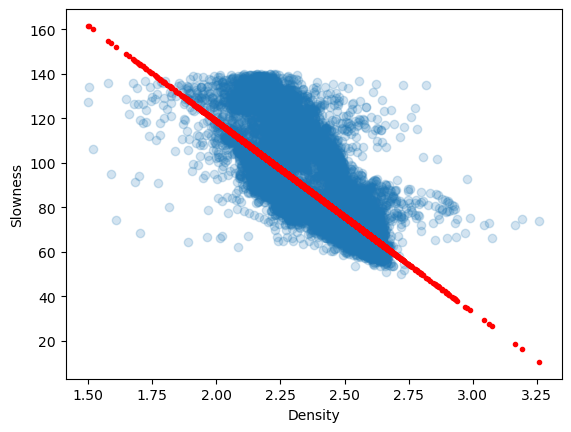

In [ ]:
# Scatter plot and regression line for training data
plt.scatter(train4_df.ZDEN, train4_df.DTC, alpha=0.2)
plt.plot(train4_df.ZDEN, model4.intercept_ + train4_df.ZDEN *
         model4.coef_[0] +
         np.mean(train4_df.GR)*model4.coef_[1], '.r')
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()


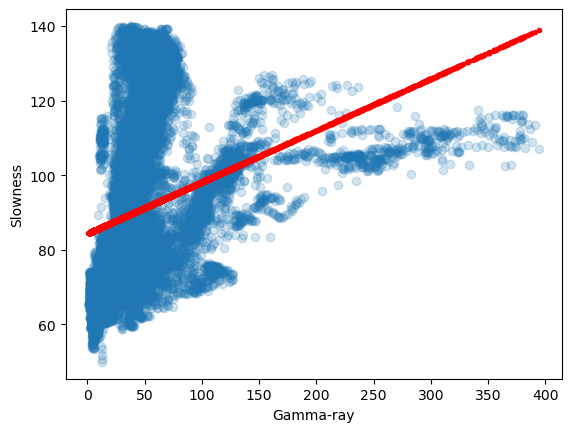

In [ ]:
# Scatter plot and regression line for training data
plt.scatter(train4_df.GR, train4_df.DTC, alpha=0.2)
plt.plot(train4_df.GR, model4.intercept_ + np.mean(train4_df.ZDEN)
         * model4.coef_[0] +
         train4_df.GR * model4.coef_[1] +
         np.mean(train4_df.PE) * model4.coef_[2], '.r')
plt.xlabel('Gamma-ray')
plt.ylabel('Slowness')
plt.show()


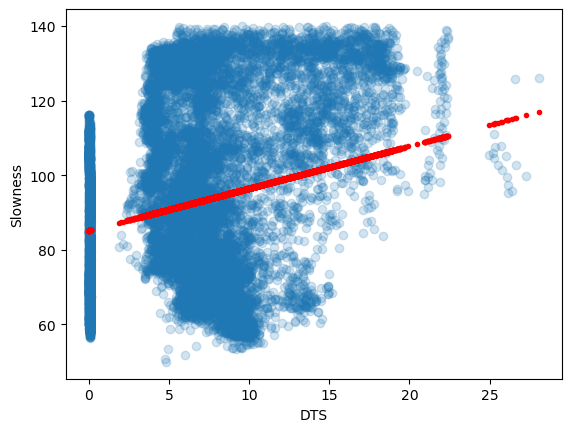

In [ ]:
# Scatter plot and regression line for training data using DTS
plt.scatter(train4_df.PE, train4_df.DTC, alpha=0.2)
plt.plot(train4_df.PE, model4.intercept_ + np.mean(train4_df.ZDEN)
         * model4.coef_[0] +
         np.mean(train4_df.GR) * model4.coef_[1] +
         train4_df.PE * model4.coef_[2], '.r')
plt.xlabel('DTS')
plt.ylabel('Slowness')
plt.show()

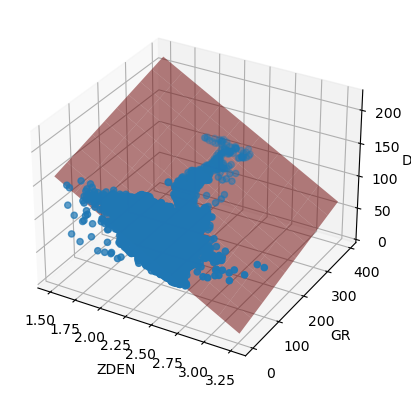

In [ ]:
# 3D surface plot for training data
D = np.linspace(np.min(train4_df.ZDEN), np.max(train4_df.ZDEN), 10)
G = np.linspace(np.min(train4_df.GR), np.max(train4_df.GR), 10)
D, G = np.meshgrid(D, G)
S = model4.intercept_ + D * model4.coef_[0] + \
    G * model4.coef_[1] + \
    np.mean(train4_df.PE) * model4.coef_[2]

fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(train4_df.ZDEN, train4_df.GR, train4_df.DTC)
axes.plot_surface(D, G, S, color='red', alpha=0.5)
axes.set_xlabel('ZDEN')
axes.set_ylabel('GR')
axes.set_zlabel('DTC')
plt.show()


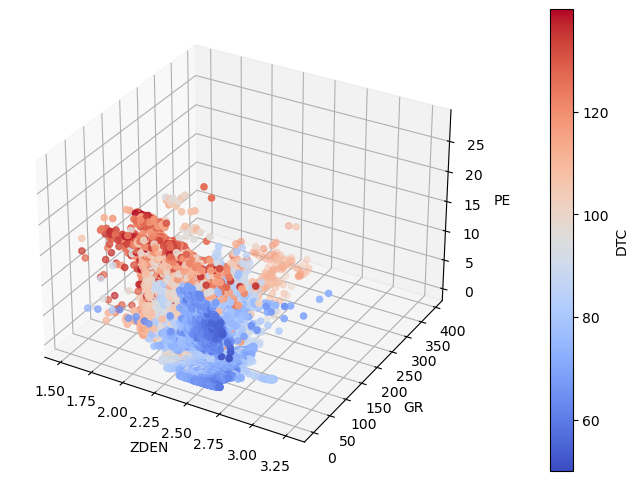

In [ ]:
# 4D scatter plot for training data
fig = plt.figure(figsize=(10, 6))
axes = fig.add_subplot(111, projection='3d')
scatter = axes.scatter(train4_df.ZDEN, train4_df.GR, train4_df.PE, c=train4_df.DTC, cmap='coolwarm')
cbar = plt.colorbar(scatter, ax=axes, pad=0.1, label='DTC')
axes.set_xlabel('ZDEN')
axes.set_ylabel('GR')
axes.set_zlabel('PE')
cbar.ax.set_ylabel('DTC')
plt.show()

## Conclusions

Simple linear regression is obviously too primitive to be of much practical use in this case.

However, it illustrates general principles of supervised learning:

1. Our goal is to predict one part of the data from the other parts.
2. To make a prediction, we build a model, which depends on parameters.
3. The parameters are estimated from training data by minimizing an objection function, which measures the prediction error.
4. Minimization generally involves a form of gradient descent (*analytical in the case of linear regression*.)
5. Part of the available data can be used for validation.
6. There are uncertainties in the parameter estimation and in the model prediction.

## <span style="color:red">Bonus Task 3</span>

Continue using the Linear Regression approach but try to improve the results by non-linear transformations of the dependent variables. The task is open-ended, but here are some possibilities to explore:

* Try predicting velocity (1/slowness) instead of slowness.

* [Gardner's equation](https://wiki.seg.org/wiki/Dictionary:Gardner%E2%80%99s_equation) suggests an empirical relationship between density and velocity of the form
$$\rho = \alpha\,v^{\beta}\;,$$
where the parameters $\alpha$ and $\beta$ depend on lithology.<br>Taking the logarithm of both sides,
<br><br>
$$\log \rho = \log{\alpha} + \beta\,\log{v}\ = \log{\alpha} - \beta\,\log{s}\;.$$
This suggests switching to logarithms in the linear regression model.

* Try other non-linear functions of logs in addition to multiple logs as independent variables in linear regression.

In [ ]:
# Train model using the original features
X_train = train4_df[['ZDEN', 'GR', 'DTS']]
y_train = 1 / train4_df['DTC']  # Predicting 1/slowness

model.fit(X_train, y_train)


In [ ]:
# Predict on the test data and calculate velocity predictions
X_test = test4_df[['ZDEN', 'GR', 'DTS']]
velocity_predictions = 1 / model.predict(X_test)


In [ ]:
# Calculate RMS error on the velocity predictions
rms_error = mean_squared_error(test4_df['DTS'], velocity_predictions, squared=False)
print("RMS error predicting velocity:", rms_error)


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(test4_df['DTS'], velocity_predictions, color='blue', alpha=0.6)
plt.plot([0, 500], [0, 500], color='red', linestyle='--')  # Identity line
plt.xlabel('Actual DTS')
plt.ylabel('Predicted Velocity (1/Slowness)')
plt.title('Predicted Velocity vs Actual DTS')
plt.grid(True)
plt.show()


In [ ]:
# Create a 4D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract data for plotting
actual_zden = test4_df['ZDEN']
actual_gr = test4_df['GR']
actual_dts = test4_df['DTS']
predicted_velocity = velocity_predictions

# Create the scatter plot
scatter = ax.scatter(actual_zden, actual_gr, actual_dts, c=predicted_velocity, cmap='viridis')

# Add labels and title
ax.set_xlabel('Actual ZDEN')
ax.set_ylabel('Actual GR')
ax.set_zlabel('Actual DTS')
ax.set_title('4D Scatter Plot: Predicted Velocity vs Actual ZDEN, GR, DTS')

# Add colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Predicted Velocity (1/Slowness)')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 4D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract data for plotting
actual_zden = test4_df['ZDEN']
actual_gr = test4_df['GR']
actual_dts = test4_df['DTS']
predicted_velocity = velocity_predictions

# Create the scatter plot
scatter = ax.scatter(actual_zden, actual_gr, actual_dts, c=predicted_velocity, cmap='viridis')

# Add labels and title
ax.set_xlabel('Actual ZDEN')
ax.set_ylabel('Actual GR')
ax.set_zlabel('Actual DTS')
ax.set_title('4D Scatter Plot: Predicted Velocity vs Actual ZDEN, GR, DTS')

# Add colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Predicted Velocity (1/Slowness)')

# Plot the surface of RMSE
a = np.linspace(model.intercept_ - 10, model.intercept_ + 10, 100)
b = np.linspace(model.coef_[0] - 0.1, model.coef_[0] + 0.1, 100)
A, B = np.meshgrid(a, b)
error = np.array([[mean_squared_error(test4_df['DTC'], A[i,j] + B[i,j]*actual_zden + model.coef_[1]*actual_gr + model.coef_[2]*actual_dts, squared=False) for j in range(100)] for i in range(100)])
plt.contour(a, b, error, [50, 100, 150, 200, 250, 300, 350], cmap='jet')
plt.plot(model.intercept_, model.coef_[0], marker='.')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.colorbar()

# Show the plot
plt.show()


# Gardeners Equation
## Failed

In [ ]:
five = logs.loc[:, ['ZDEN', 'GR', 'DTC', 'DTS']]
five.replace(-999, np.nan, inplace=True)
five.dropna(inplace=True)

# Convert to Pandas DataFrame
five_df = pd.DataFrame(five, columns=['ZDEN', 'GR', 'DTC', 'DTS'])
# Remove anomalous density, slowness, and DTS values
five2_df = five_df.loc[(five_df.ZDEN > 1.5) & (five_df.ZDEN < 3.1) &
                       (five_df.GR < 400) & (five_df.DTS < 500)]


In [ ]:
# Divide into training and testing using Pandas DataFrames
select5 = np.random.rand(len(five2_df)) < 0.8
train5_df = five2_df[select5]
test5_df = five2_df[~select5]

# Display information about the training DataFrame
print("Info for train5_df DataFrame:")
print(train5_df.info())

In [ ]:
# Create explicit copies of the DataFrames
train5_df = train5_df.copy()
test5_df = test5_df.copy()
# Apply logarithmic transformation to target variable 'DTC' using Gardner's equation
alpha = 310  # Adjust the value of alpha based on your data
beta = 0.25  # Adjust the value of beta based on your data
train5_df['log_rho'] = np.log(alpha) - beta * np.log(train5_df['DTC'])


# Apply logarithmic transformation to feature 'ZDEN' for test data
test5_df['log_ZDEN'] = np.log(test5_df['ZDEN'])


In [ ]:
# Create model
model_log = linear_model.LinearRegression()

# Train model using the transformed features
X_train_log = train5_df[['log_ZDEN', 'GR', 'DTS']]
y_train_log = train5_df['log_rho']
model_log.fit(X_train_log, y_train_log)


In [ ]:
# Apply logarithmic transformation to test features
test5_df['log_ZDEN'] = np.log(test5_df['ZDEN'])

# Predict on the test data and calculate predicted density
log_predictions = model_log.predict(test5_df[['log_ZDEN', 'GR', 'DTS']])
predicted_density = np.exp(log_predictions)

In [ ]:
# Calculate predicted velocity using Gardner's equation
predicted_velocity = alpha * (predicted_density ** beta)


In [ ]:
# Calculate RMS error on the original scale
rms_error = mean_squared_error(test5_df['DTC'], predictions, squared=False)
print("RMS error with logarithmic transformation:", rms_error)


In [ ]:
print("Length of test5_df['DTC']: ", len(test5_df['DTC']))
print("Shape of predicted_velocity_grid: ", predicted_velocity_grid.shape)


In [ ]:
print("Predicted Velocity Statistics:")
print("Min:", np.min(predicted_velocity_grid))
print("Max:", np.max(predicted_velocity_grid))
print("Mean:", np.mean(predicted_velocity_grid))
print("Median:", np.median(predicted_velocity_grid))

print("\nActual Velocity (DTC) Statistics:")
print("Min:", np.min(test5_df['DTC']))
print("Max:", np.max(test5_df['DTC']))
print("Mean:", np.mean(test5_df['DTC']))
print("Median:", np.median(test5_df['DTC']))


In [ ]:
# Reshape predicted_velocity_grid to match the length of test5_df['DTC']
predicted_velocity_grid = predicted_velocity[:len(test5_df['DTC'])]

# Plot the scatter plot with reversed x and y values
plt.scatter(predicted_velocity_grid, test5_df['DTC'])
plt.plot([min(predicted_velocity_grid), max(predicted_velocity_grid)], [min(test5_df['DTC']), max(test5_df['DTC'])], color='red', linestyle='--')  # Identity line
plt.xlabel('Predicted Velocity')
plt.ylabel('Actual Velocity (DTC)')
plt.title("Predicted vs. Actual Velocity using Gardner's Equation")
plt.show()

In [ ]:
# Create a meshgrid of values for the three features
ZDEN_vals = np.linspace(np.min(test5_df['log_ZDEN']), np.max(test5_df['log_ZDEN']), 10)
GR_vals = np.linspace(np.min(test5_df['GR']), np.max(test5_df['GR']), 10)
DTS_vals = np.linspace(np.min(test5_df['DTS']), np.max(test5_df['DTS']), 10)
ZDEN_grid, GR_grid, DTS_grid = np.meshgrid(ZDEN_vals, GR_vals, DTS_vals)

In [ ]:
# Create the grid for predicted velocity
log_predictions_grid = model_log.predict(np.vstack((ZDEN_grid.ravel(), GR_grid.ravel(), DTS_grid.ravel())).T)
predicted_velocity_grid1 = alpha * (np.exp(log_predictions_grid) ** beta)
